# PARTE III - Desafio Modelo Preditivo
Agora que limpamos o dataset e fizemos a análise exploratória dos dados, está na hora de irmos fazer o modelo preditivo.

## Objetivo Principal
Desenvolver um **modelo preditivo** capaz de estimar a probabilidade de inadimplência de cobranças mensais feitas aos clientes.

A **inadimplência** é definida da seguinte forma:
> Um pagamento é considerado inadimplente se for realizado com **5 dias ou mais de atraso** em relação à data de vencimento.

As previsões devem conter apenas a probabilidade de inadimplência (valores entre 0 e 1).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Lendo o dataset para treinamento  
df_treino = pd.read_csv("dataset_limpo.csv", sep = ",")

Irei abordar dois tipos de Machine Learning:
1. Regressão Logística
2. Random Forest

Vamos ver qual das duas se sai melhor neste caso.

# 1 Regressão Logística

In [3]:
from sklearn.linear_model import LogisticRegression
# Divisão entre treino e teste
from sklearn.model_selection import train_test_split

# Divisão entre target e o que será usado no modelo
X = df_treino.drop('INADIMPLENCIA', axis=1)
y = df_treino['INADIMPLENCIA']


# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Treino do Modelo
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/rafael/Downloads/datarisk-case-ds-junior-master/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [4]:
logreg.score(X_test,y_test)

0.932315258185583

In [5]:
log_pred = logreg.predict(X_test)

## 1.1 Avaliação do Modelo

In [6]:
from sklearn import metrics

Text(8.222222222222223, 0.5, 'Rótulos Previstos')

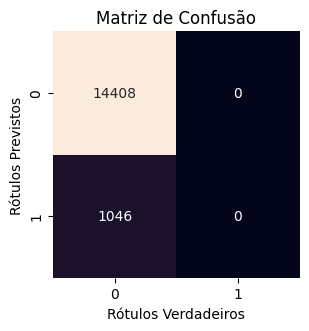

In [7]:
# Matrix de Confusão
conf_matrix = metrics.confusion_matrix(y_test, log_pred)

# Gráfico
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(conf_matrix, annot=True, cbar=False, fmt='d')
plt.tight_layout()
plt.title('Matriz de Confusão')
plt.xlabel('Rótulos Verdadeiros')
plt.ylabel('Rótulos Previstos')

Métricas de avaliação da matriz de confusão


In [8]:
from sklearn.metrics import classification_report

report = classification_report(y_test, log_pred, output_dict=True)
df_report = pd.DataFrame(report).T
df_report.style.background_gradient(cmap='Blues').format('{:.2f}')

/home/rafael/Downloads/datarisk-case-ds-junior-master/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/rafael/Downloads/datarisk-case-ds-junior-master/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/rafael/Downloads/datarisk-case-ds-junior-master/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

,precision,recall,f1-score,support
0,0.93,1.00,0.96,14408.00
1,0.00,0.00,0.00,1046.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.47,0.50,0.48,15454.00
weighted avg,0.87,0.93,0.90,15454.00


Podemos interpretar esses resultados da seguinte forma:
- A base é **altamente desbalanceada**;
- O modelo está priorizando **acurácia**, que engana nesses resultados.

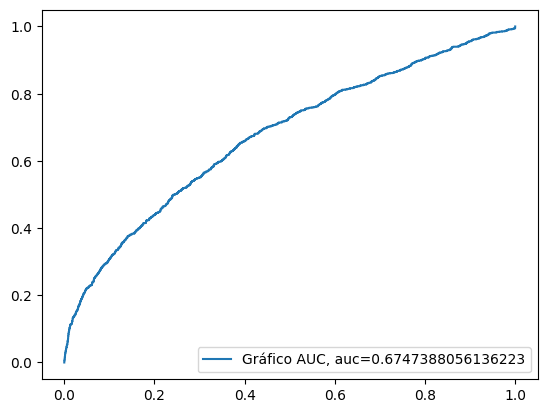

In [9]:
from sklearn.metrics import RocCurveDisplay

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Gráfico AUC, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# 1.2 Uma Nova Abordagem - StandardScaler

Vamos tentar melhorar essa perfomance usando uma estrátegia de normalização dos dados.

In [10]:
from sklearn.preprocessing import StandardScaler

# Padronização
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo
logreg_scaler = LogisticRegression()
logreg_scaler.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [11]:
logreg_scaler_pred = logreg_scaler.predict(X_test_scaled)

Text(8.222222222222223, 0.5, 'Rótulos Previstos')

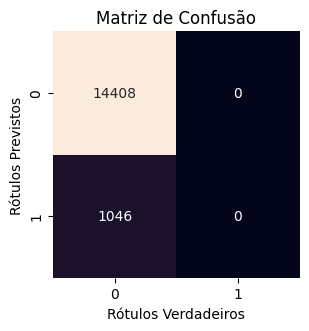

In [12]:
# Matriz de Confusão
conf_matrix_scaler = metrics.confusion_matrix(y_test, logreg_scaler_pred)

fig, ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(conf_matrix_scaler, annot=True, cbar=False, fmt='d')
plt.tight_layout()
plt.title('Matriz de Confusão')
plt.xlabel('Rótulos Verdadeiros')
plt.ylabel('Rótulos Previstos')

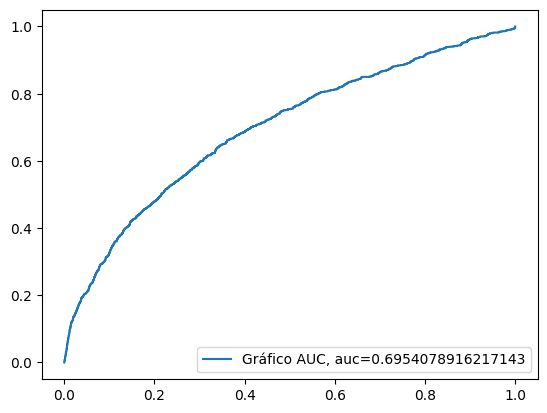

In [13]:
y_pred_proba_scaler = logreg_scaler.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_scaler)
auc = metrics.roc_auc_score(y_test, y_pred_proba_scaler)
plt.plot(fpr,tpr,label="Gráfico AUC, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Não houve melhoria significativa. Vamos adotar outra abordagem, agora vamos seguir para outro modelo de Machine Learning e comparar os resultados.

# 2 Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 2.2 Avaliando o Modelo

In [15]:
forest_pred = forest.predict(X_test)
forest_conf_matrix = metrics.confusion_matrix(y_test,forest_pred)

Text(8.222222222222223, 0.5, 'Rótulos Previstos')

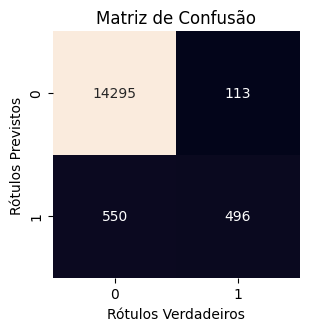

In [16]:
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(forest_conf_matrix, annot=True, cbar=False, fmt='d')
plt.tight_layout()
plt.title('Matriz de Confusão')
plt.xlabel('Rótulos Verdadeiros')
plt.ylabel('Rótulos Previstos')

Aqui temos uma melhoria, o modelo Random Forest soube acertar com mais precisão os casos.

In [17]:
forest.score(X_test,y_test)

0.9570984858289117

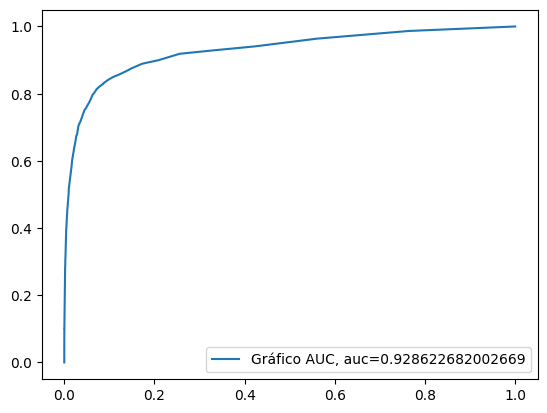

In [18]:
forest_pred_proba = forest.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  forest_pred_proba)
auc = metrics.roc_auc_score(y_test, forest_pred_proba)
plt.plot(fpr,tpr,label="Gráfico AUC, auc="+str(auc))
plt.legend(loc=4)
plt.show()

- A curva ROC mostra que o modelo possui boa capacidade discriminativa.
- O AUC = 0.92 indica que, em 92% das vezes, o modelo consegue dar um score mais alto para uma instância positiva do que para uma negativa.
- A curva ROC colada no topo significa alta sensibilidade e baixo nível de falso positivo para a maior parte dos thresholds.

In [19]:
forest_report = classification_report(y_test, forest_pred, output_dict=True)
df_forest_report = pd.DataFrame(forest_report).T
df_forest_report.style.background_gradient(cmap='Blues').format('{:.2f}')

,precision,recall,f1-score,support
0,0.96,0.99,0.98,14408.00
1,0.81,0.47,0.60,1046.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.89,0.73,0.79,15454.00
weighted avg,0.95,0.96,0.95,15454.00


RandomForest se sai melhor neste caso.

# 3 Conclusão
A análise comparativa evidenciou que o **Random Forest** oferece melhor desempenho geral do que o Logistic Regression, indicando que é o modelo mais adequado para uso na prática. Sua capacidade de lidar com dados não lineares, variáveis categóricas e interações complexas permitiu resultados mais precisos e maior estabilidade.

Considerando as métricas avaliadas e o objetivo do projeto, **recomenda-se a adoção do Random Forest**, uma vez que o modelo apresenta melhor capacidade preditiva e maior adaptabilidade ao comportamento do conjunto de dados analisado.